# Uber Trips and Pickups Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"timstracke","key":"9099eb0161d5456f24cc570621da25d6"}'}

In [4]:
!pip install kaggle

In [5]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d fivethirtyeight/uber-pickups-in-new-york-city

 89% 97.0M/109M [00:03<00:00, 22.0MB/s]
100% 109M/109M [00:03<00:00, 34.4MB/s] 


In [7]:
from zipfile import ZipFile
file_name = "uber-pickups-in-new-york-city.zip"

with ZipFile(file_name, "r") as zipped:
  zipped.extractall()
  

## Exploratory Data Analysis

In [8]:
uber_janjune15 = pd.read_csv("uber-raw-data-janjune-15.csv")

In [9]:
uber_apr14 = pd.read_csv("uber-raw-data-apr14.csv")
uber_may14 = pd.read_csv("uber-raw-data-may14.csv")
uber_jun14 = pd.read_csv("uber-raw-data-jun14.csv")
uber_jul14 = pd.read_csv("uber-raw-data-jul14.csv")
uber_aug14 = pd.read_csv("uber-raw-data-aug14.csv")
uber_sep14 = pd.read_csv("uber-raw-data-sep14.csv")

In [10]:
uber14 = pd.concat([uber_apr14, uber_may14, uber_jun14, uber_jul14, uber_aug14, uber_sep14])

In [11]:
uber_janjune15 = uber_janjune15.rename(columns={"Pickup_date": "Date/Time", "Dispatching_base_num": "Base"})

In [12]:
#uber_data = pd.merge(uber14, uber_janjune15, left_on=["Date/Time", "Base"], right_on=["Date/Time", "Base"], how="outer")

In [13]:
uber_janjune15["Date/Time"] = pd.to_datetime(uber_janjune15["Date/Time"])

In [14]:
hourly_drives = uber_janjune15[["Date/Time"]].resample("H", on="Date/Time").count()

In [15]:
# Setting up a dataframe with the average trips per hour
hourly_drives = uber_janjune15[["Date/Time"]].resample("H", on="Date/Time").count()
avg_hourly_drives = hourly_drives.groupby(hourly_drives.index.hour).mean()
avg_hourly_drives = avg_hourly_drives.rename(columns={"Date/Time": "Average trips"})
avg_hourly_drives = avg_hourly_drives.rename_axis("Pickup_hour")

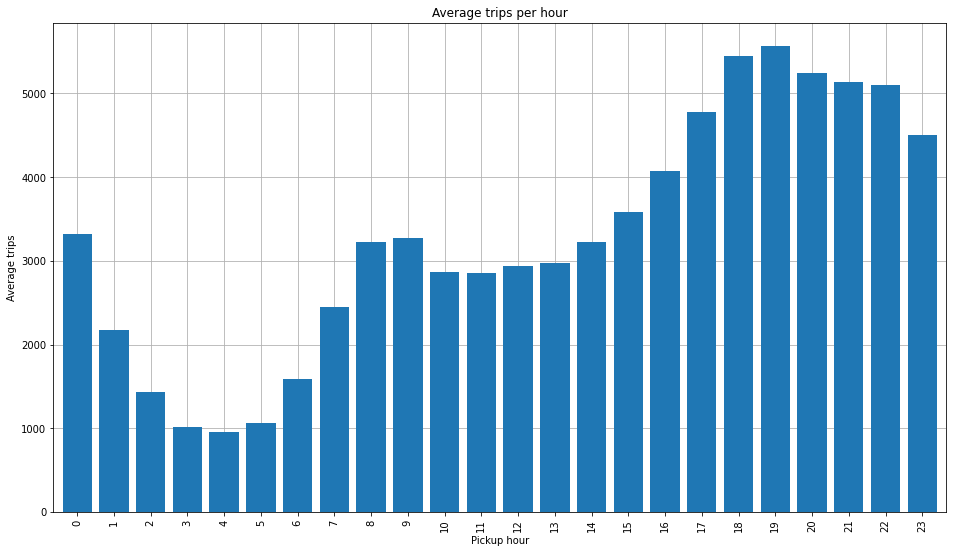

In [16]:
# Plotting the average trips per hour
ax = avg_hourly_drives.plot(kind="bar", figsize=(16,9), width=0.8, xlabel="Pickup hour", ylabel="Trips", zorder=3, legend=None, title="Average trips per hour")
ax.grid(zorder=-1)
ax.set_ylabel("Average trips");

Generally, there are more uber trips in the evening than in the morning. The amount of trips per hour is peaking from 7pm until 8pm.

In [17]:
# Setting up a dataframe with the number of daily trips
daily_drives = uber_janjune15[["Date/Time"]].resample("D", on="Date/Time").count()
daily_drives = daily_drives.rename(columns={"Date/Time": "Daily Trips"})

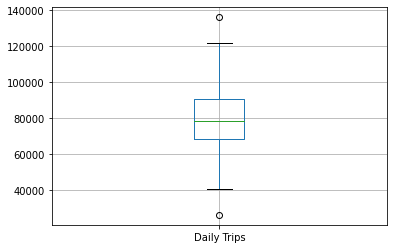

In [18]:
daily_drives.boxplot()

In [19]:
# Setting up a dataframe with the average trips for every weekday
weekdays = daily_drives.groupby(daily_drives.index.weekday).mean()
weekdays = weekdays.rename(columns={"Daily Trips": "Average daily trips"})
weekdays = weekdays.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})

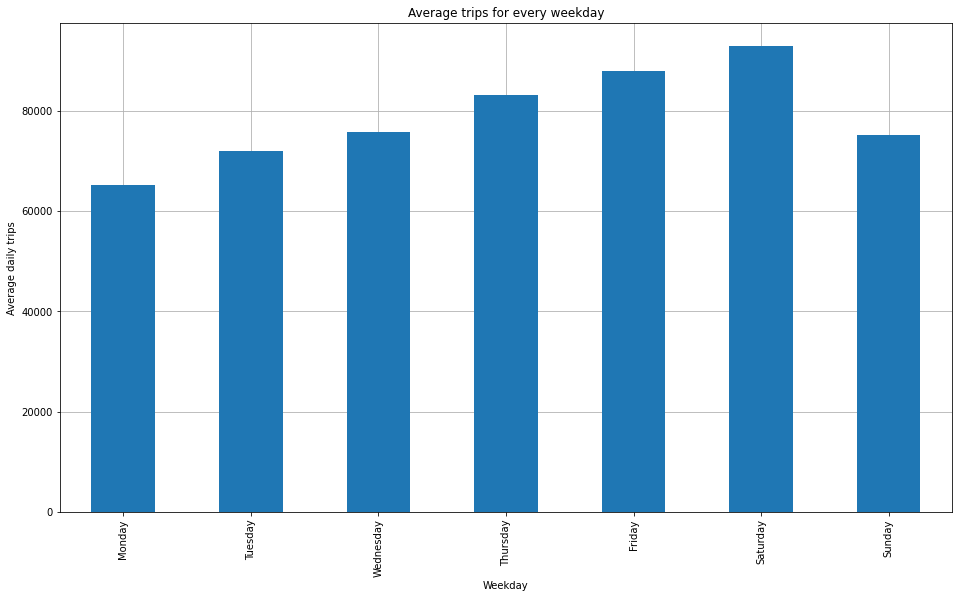

In [20]:
# Plotting the average trips for every weekday
ax = weekdays.plot(kind="bar", figsize=(16,9), xlabel="Weekday", zorder=3, legend=None, title="Average trips for every weekday")
ax.grid(zorder=1)
ax.set_ylabel("Average daily trips"); 

The uber trips are generally the lowest on mondays and then rise until they hit its peak on saturday.

In [21]:
# Setting up a dataframe with the average daily trips for each month
monthly = daily_drives.groupby([daily_drives.index.month]).mean()
monthly = monthly.rename(index={1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June"})

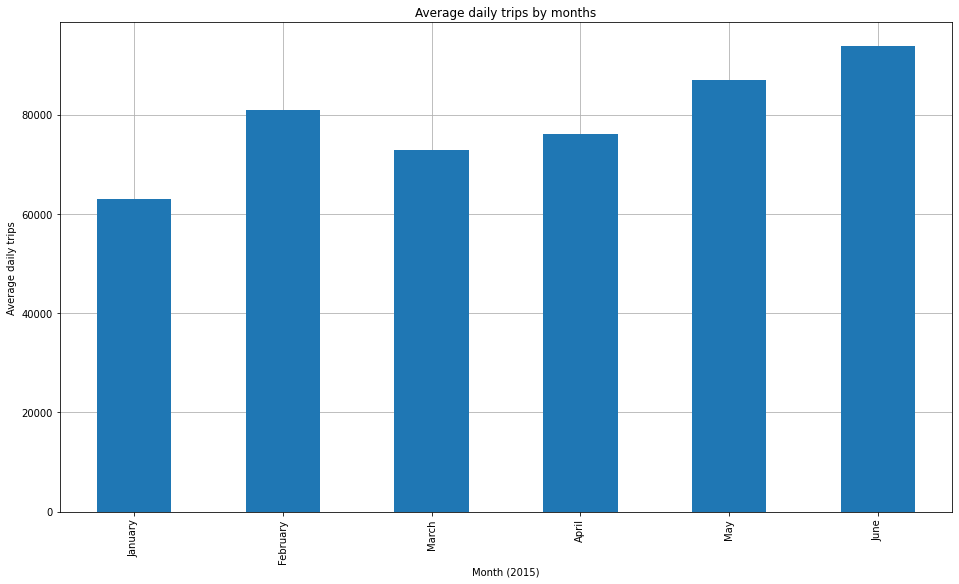

In [22]:
# Plotting the average daily trips for each month
ax = monthly.plot(kind="bar", figsize=(16,9), zorder=3, legend=False)
ax.grid(zorder=1)
ax.set_xlabel("Month (2015)")
ax.set_ylabel("Average daily trips")
ax.set_title("Average daily trips by months");

Uber saw an increase in trips from january through june. In february, the amount of trips was notably higher, which might be due to the cold wave in New York in February 2015.

In [23]:
month_and_weekday = daily_drives.groupby([daily_drives.index.month, daily_drives.index.weekday]).mean()
month_and_weekday = month_and_weekday.rename_axis(["Month", "Weekday"])
month_and_weekday = month_and_weekday.unstack()
month_and_weekday.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_and_weekday.index = ["January", "February", "March", "April", "May", "June"]

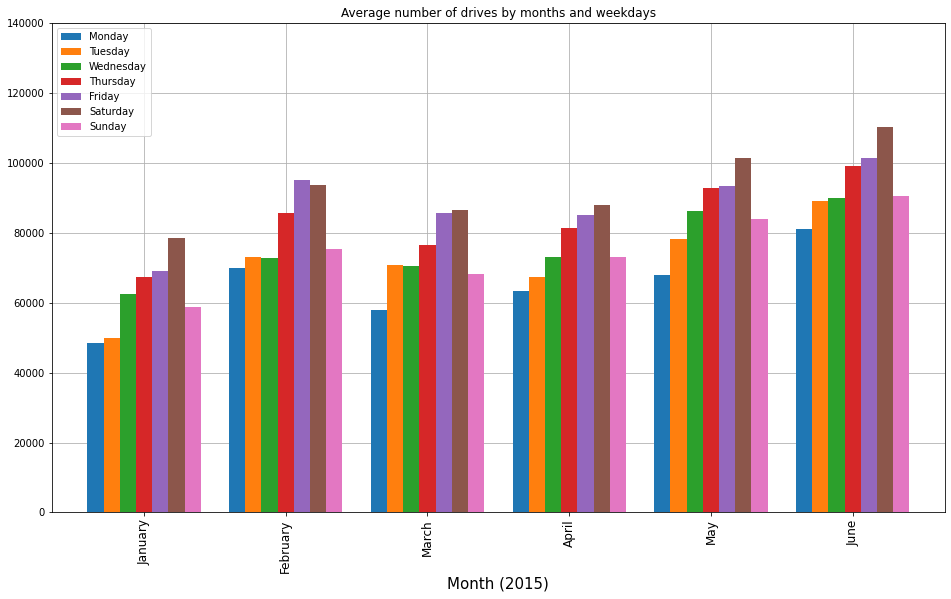

In [24]:
# Plotting the average trips by month and weekday
ax = month_and_weekday.plot(kind="bar", figsize=(16,9), width=0.8, zorder=3)
leg = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax.set_title("Average number of drives by months and weekdays")
ax.tick_params(axis='x', which='major', labelsize=12)
ax.set_xlabel("Month (2015)", fontsize=15)
ax.set_ylim((0,140000))
ax.grid(zorder=1);

The spread of weekly trips among the seven weekdays is very similar for all shown months. The number of trips is always at its highest on friday or saturday and at its lowest on monday.

### Geographical plotting

In [25]:
import plotly.express as px

In [48]:
# Creating a sample of the data, because of plotly having a cap of 500000 data points for their geographical plots.
uber14_sample = uber14.sample(n=100000)

In [50]:
# Plotting the pickup locations with different colors for the respective bases
fig = px.scatter_mapbox(uber14_sample, lat="Lat", lon="Lon", zoom=9, color="Base", mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

It seems like Base B02512 (orange) is primarily operating in Manhattan while the other bases are spread equally among New York.

In [51]:
# Plotting the density of the pickup locations
fig = px.density_mapbox(uber14_sample, lat='Lat', lon='Lon', radius=1, zoom=9, mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

The majority of the uber pickups are in Manhattan. Brooklyn and Queens are also quite popular pickup locations.  
You can also see that there were a lot of pickups near John F. Kennedy Airport and Newark Liberty International Airport.

## Linear Regression Analysis

In [30]:
weather = files.upload()

Saving nycweather.csv to nycweather.csv


In [31]:
weather_nyc = pd.read_csv("nycweather.csv")

In [32]:
weather_nyc.head()

,EST,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0,1018.0,1015.0,16.0,16.0,16.0,27.0,11.0,50.0,0.00,0.0,NaN,254
1,2015-1-2,6,4,2,-7,-8,-9,52,43,33,1031.0,1023.0,1016.0,16.0,16.0,16.0,24.0,11.0,40.0,0.00,1.0,NaN,278
2,2015-1-3,6,3,1,4,-2,-9,92,68,44,1036.0,1030.0,1019.0,16.0,7.0,1.0,19.0,10.0,29.0,18.03,6.0,Rain-Snow,75
3,2015-1-4,13,9,5,10,6,-3,93,88,83,1019.0,1012.0,1004.0,16.0,9.0,1.0,47.0,10.0,74.0,7.62,7.0,Rain,274
4,2015-1-5,9,2,-6,-3,-12,-19,49,38,26,1030.0,1020.0,1009.0,16.0,16.0,16.0,39.0,17.0,61.0,0.00,2.0,NaN,291


In [33]:
weather_nyc["EST"] = pd.to_datetime(weather_nyc["EST"])

In [34]:
daily_drives_weather = pd.merge(daily_drives, weather_nyc[["Mean TemperatureC", "Precipitationmm", " Events"]], right_on=weather_nyc["EST"], left_on=daily_drives.index)

In [35]:
daily_drives_weather.head()

,key_0,Daily Trips,Mean TemperatureC,Precipitationmm,Events
0,2015-01-01,58045,1,0.00,NaN
1,2015-01-02,40287,4,0.00,NaN
2,2015-01-03,59844,3,18.03,Rain-Snow
3,2015-01-04,41943,9,7.62,Rain
4,2015-01-05,43678,2,0.00,NaN


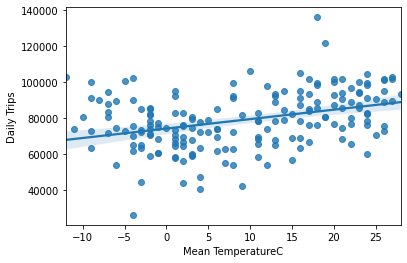

In [36]:
# Plotting the relationship between temperature and number of trips 
temp_drives = sns.regplot(x="Mean TemperatureC", y="Daily Trips", data=daily_drives_weather)

In [37]:
daily_drives_weather["Precipitationmm"] = pd.to_numeric(daily_drives_weather["Precipitationmm"], errors="coerce").fillna(0)

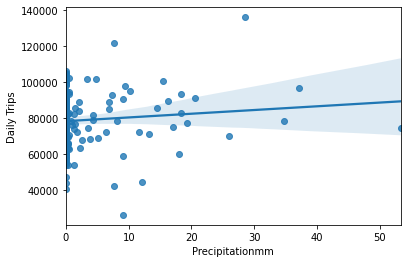

In [38]:
# Plotting the relationship between precipitation and number of trips
prec_drives = sns.regplot(x="Precipitationmm", y="Daily Trips", data=daily_drives_weather)

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [40]:
# Setting up independent and dependent variables
X = daily_drives_weather[["Mean TemperatureC", "Precipitationmm"]]
y = daily_drives_weather["Daily Trips"]

In [41]:
# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
# Linear Regression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [43]:
# Print the intercept
print(lin_reg.intercept_)

72481.22343930902


In [44]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Mean TemperatureC,614.461011
Precipitationmm,248.240344


In [45]:
# Predicting the daily trips for the test data based on temperature and precipitation
pred = lin_reg.predict(X_test)

Text(0, 0.5, 'Prediction')

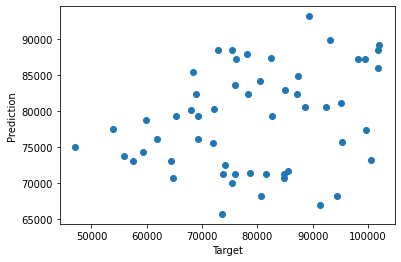

In [46]:
# Comparing the predictions with the targets (test data)
plt.scatter(y_test, pred)
plt.xlabel("Target")
plt.ylabel("Prediction")

In [47]:
mae = metrics.mean_absolute_error(y_test, pred)
mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
r2_score = metrics.r2_score(y_test, pred)
print("Median Absolute Error:", mae)
print("Median Squared Error:", mse)
print("Root Median Squared Error:", rmse)
print("R2 Score:", r2_score)

Median Absolute Error: 11556.533530858374
Median Squared Error: 178976880.44766906
Root Median Squared Error: 13378.224114121764
R2 Score: 0.03019298256802183


The model does not predict the amount of daily trips well. This might be due to a lack of data or due to a lack of an influence the weather has on the amount of trips.